[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_15836/883678116.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSI'].fillna(50, inplace=True)
/home/simenwei/dev/fyp/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Root Mean Square Error (RMSE): 76.0537
Mean Square Error (MSE): 5784.1709
Mean Absolute Error (MAE): 66.4429
Mean Absolute Percentage Error (MAPE): 0.3546


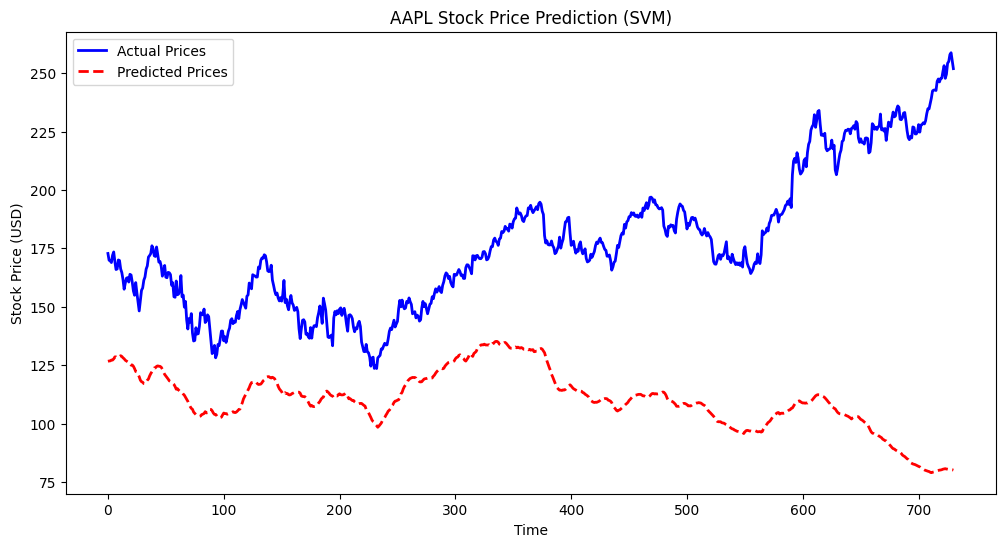

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt

# Function to download stock data
def download_stock_data(ticker, start_date='2010-01-01', end_date='2024-12-31'):
    buffer_start = pd.to_datetime(start_date) - pd.DateOffset(years=1)
    data = yf.download(ticker, start=buffer_start.strftime('%Y-%m-%d'), end=end_date)
    
    ticker_data = yf.Ticker(ticker)
    earnings_dates = set(pd.to_datetime(ticker_data.earnings_dates.index).normalize())
    ex_dividend_dates = set(pd.to_datetime(ticker_data.dividends.index).normalize())
    dates_to_remove = earnings_dates.union(ex_dividend_dates)
    
    data.index = pd.to_datetime(data.index).normalize()
    data = data[~data.index.isin(dates_to_remove)]
    data = data.loc[start_date:]
    
    return data

# Function to add technical indicators
def add_technical_indicators(df):
    df['20MA'] = df['Close'].rolling(window=20, min_periods=1).mean()
    df['50MA'] = df['Close'].rolling(window=50, min_periods=1).mean()
    df['200MA'] = df['Close'].rolling(window=200, min_periods=1).mean()
    
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['RSI'].fillna(50, inplace=True)
    
    df['12EMA'] = df['Close'].ewm(span=12, adjust=False, min_periods=1).mean()
    df['26EMA'] = df['Close'].ewm(span=26, adjust=False, min_periods=1).mean()
    df['MACD'] = df['12EMA'] - df['26EMA']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False, min_periods=1).mean()
    
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    
    return df

# Normalize the data
def normalize_data(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[['Close', '20MA', '50MA', '200MA', 'RSI', 'MACD']])
    return scaled_data, scaler

# Create lag features for time series
def create_time_series_data(df, scaled_data, window_size=120):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i])
        y.append(df['Close'].iloc[i])
    return np.array(X), np.array(y)

# Split data into training and testing sets
def split_data(X, y, train_size=0.7, val_size=0.1, test_size=0.2):
    train_end = int(len(X) * train_size)
    val_end = train_end + int(len(X) * val_size)

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    return X_train, X_val, X_test, y_train, y_val, y_test

# Example usage
ticker = 'AAPL'
df = download_stock_data(ticker)
df = add_technical_indicators(df)

scaled_data, scaler = normalize_data(df)
X, y = create_time_series_data(df, scaled_data)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

# Flatten for SVM input
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train SVM model
svm_model = SVR(kernel='rbf', C=100, gamma=0.01, epsilon=0.1)
svm_model.fit(X_train_flat, y_train)

# Predictions
predictions = svm_model.predict(X_test_flat)

# Compute Metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Mean Square Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices", color="blue", linewidth=2)
plt.plot(predictions, label="Predicted Prices", color="red", linestyle="dashed", linewidth=2)
plt.title(f"{ticker} Stock Price Prediction (SVM)")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()
